
# Project: Investigate a Dataset - [TMDB's Movie Data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> TMDB Dataset is a huge reference for more than 10,000 movie data form wide range of film industry history, Which we will engaged to have a precise point of view about many relationships between movie characteristics, This relations enable us to predict future performance of published movies.

> **Data consistency**:
> Dataset consist of alot of neccessary information such as:( Budget, Revenue, Cast, Director, Genre) this data can be a key word give us a reason why any movie pass or fail.


### Question(s) for Analysis
<ul>
<li><a href="#q1">Explore Qestion1: Which Genres Are Most Popular From Year To Year?</a></li>
<li><a href="#q2">Explore Question 2 Which Movies With Highest and Lowest Revenur?</a></li>
<li><a href="#q3">Explore Question 3 How Modernity of Movie Affect on Voting?</a></li>
<li><a href="#q4">Explore Question 4 How much Each Company Contribute Filming Industry?</a></li>
<li><a href="#q5">Explore Question 5 Number Of Released Movies Variation Thru Years?</a></li>
<li><a href="#q6">Explore Question 6 Which Director Has More Movies?</a></li>
</ul>

In [3]:
# Import statements for all of the packages.

import numpy as np
import pandas as pd
import seaborn as sns #To enhance visualization
import matplotlib.pyplot as plt #To enable ploting
%matplotlib inline
sns.set(color_codes = True)
from wordcloud import WordCloud


In [ ]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling


### Reading Data

In [10]:
# Load data.
df = pd.read_csv('tmdb-movies.csv') 


### Print Sample of data

In [11]:
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


### Print Data Shape

In [14]:
print(df.shape) #Output as (Rows,Columns)

(10866, 21)


### Printing Data Columns Names

> Neccessary information for all successive operation

In [15]:
print(list(df.columns.values))

['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview', 'runtime', 'genres', 'production_companies', 'release_date', 'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj']



### Data Cleaning


### Inspect is There Null Values
> Need to be cleaned in successive step

In [16]:
df.count()

id                      10866
imdb_id                 10856
popularity              10866
budget                  10866
revenue                 10866
original_title          10866
cast                    10790
homepage                 2936
director                10822
tagline                  8042
keywords                 9373
overview                10862
runtime                 10866
genres                  10843
production_companies     9836
release_date            10866
vote_count              10866
vote_average            10866
release_year            10866
budget_adj              10866
revenue_adj             10866
dtype: int64

### Erase Null Rows values

In [21]:
df = df[df["cast"].isnull() == False] # Erase movies without casts
df = df[df["genres"].isnull() == False] # Erase movies without genres
df = df[df["production_companies"].isnull() == False] # Erase movies without production company
df = df[df["director"].isnull() == False] # Erase movies without director name

df = df[df.budget_adj != 0] # Erase movies with illogical zero budget
df = df[df.revenue_adj != 0] # Erase movies with illogical zero revenue

### Dataset Count After Elemination

In [26]:
df.count()

id                      3806
popularity              3806
budget                  3806
revenue                 3806
original_title          3806
cast                    3806
director                3806
keywords                3678
overview                3806
runtime                 3806
genres                  3806
production_companies    3806
release_date            3806
vote_count              3806
vote_average            3806
release_year            3806
budget_adj              3806
revenue_adj             3806
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis


### Descriptive Statistics

> **First** : Quick Smmary Statistics 

In [27]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,3806.000000,3806.000000,3.806000e+03,3.806000e+03,3806.000000,3806.000000,3806.000000,3806.000000,3.806000e+03,3.806000e+03
mean,40040.938518,1.203625,3.760600e+07,1.089450e+08,109.346558,534.047556,6.170257,2001.231477,4.471590e+07,1.386797e+08
std,67576.835878,1.480407,4.231641e+07,1.772829e+08,19.845063,883.668197,0.792560,11.329019,4.488171e+07,2.169803e+08
min,5.000000,0.010335,1.000000e+00,2.000000e+00,15.000000,10.000000,2.200000,1960.000000,9.693980e-01,2.370705e+00
25%,5932.500000,0.470673,1.000000e+07,1.429262e+07,96.000000,74.000000,5.700000,1995.000000,1.354637e+07,1.923514e+07
50%,11255.000000,0.810226,2.500000e+07,4.620904e+07,106.000000,208.500000,6.200000,2004.000000,3.038360e+07,6.283467e+07
75%,38703.500000,1.387058,5.000000e+07,1.260625e+08,119.000000,584.000000,6.700000,2010.000000,6.083489e+07,1.657273e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


<a id = "q1"> </a>
### Research Question 1 (Which genres are most popular from year to year?)


> **Data generation**

In [34]:
data_genre = df['genres'].str.get_dummies(sep='|') #Slice genres column's data to obtain each genre family solely
data_genre1 = data_genre.sum().reset_index() #Sumption of each genre family members


> **Data Generated Plotting**

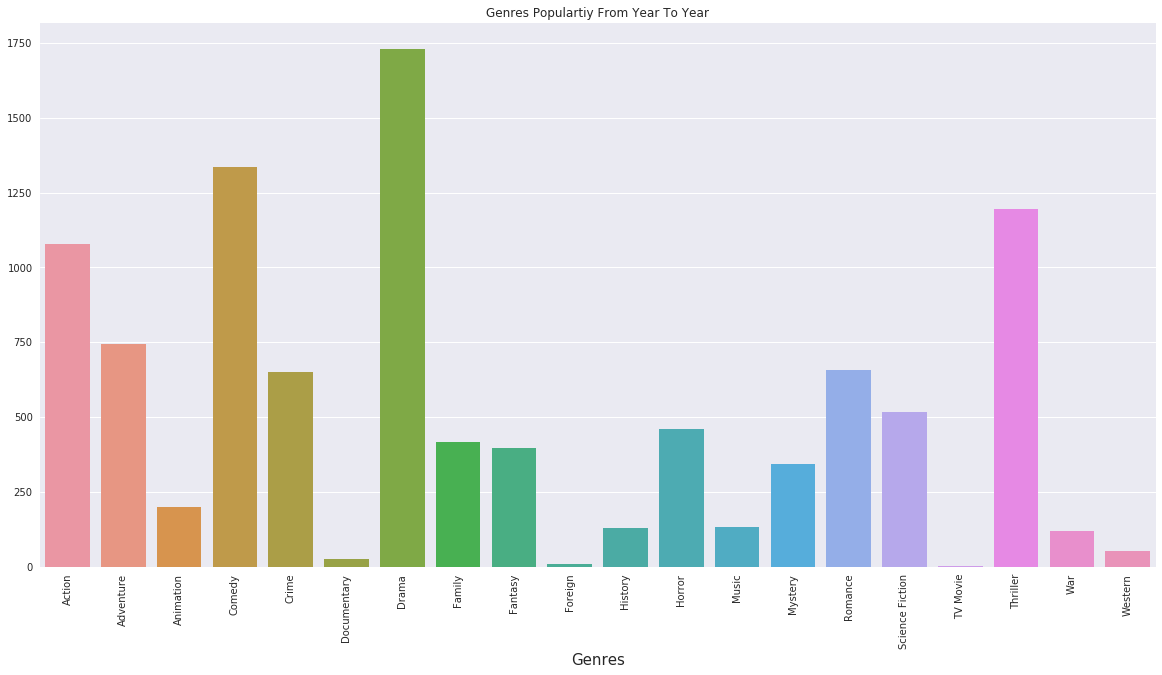

In [35]:
plt.figure(figsize=(20,10))
sns.barplot(x=data_genre.columns, y=data_genre.sum(), data = data_genre1)
plt.title('Genres Populartiy From Year To Year')
plt.xlabel('Genres', fontsize = 15)
plt.ylabel('')
plt.xticks(rotation = 90)
plt.show()

<a id = "q2"> </a>
### Research Question 2 (Which Movies With High And Low Revenue)

> **Highest Revenue Movie**

In [46]:
print(df.original_title[df['revenue_adj']==df['revenue_adj'].max()])

1386    Avatar
Name: original_title, dtype: object


> **Lowest Revenue Movie**

In [44]:
print(df.original_title[df['revenue_adj']==df['revenue_adj'].min()])

5067    Shattered Glass
Name: original_title, dtype: object


> **Illustartion Figure For Difference Between Each Movie Revenue**

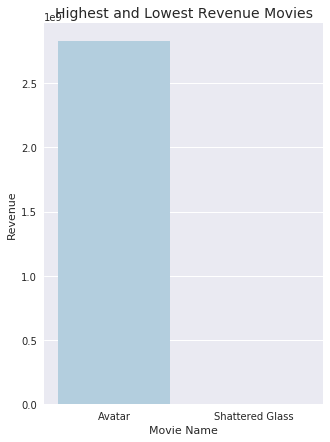

In [45]:
plt.figure(figsize=(5,7))
dd = df[(df.revenue_adj == df['revenue_adj'].max())|(df.revenue_adj==df['revenue_adj'].min())]
sns.barplot(dd['original_title'], dd['revenue_adj'], palette = 'Blues')
plt.title('Highest and Lowest Revenue Movies', fontsize = 14)
plt.xlabel('Movie Name')
plt.ylabel('Revenue')
plt.show()


> **Highest Ten Movie**

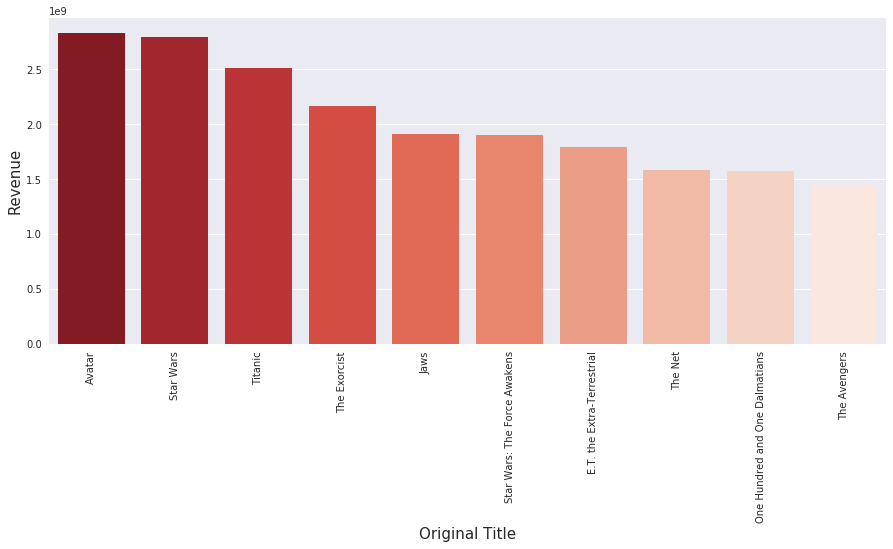

In [47]:
plt.figure(figsize=(15,6))
ds=df[['original_title', 'revenue_adj']].sort_values('revenue_adj', ascending = False).head(10)
sns.barplot(x='original_title' , y='revenue_adj', data=ds, palette='Reds_r')
plt.xlabel('Original Title', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(rotation = 90)
plt.show()

<a id = "q3"> </a>
### Research Question 3 (How Modernity of Movie Affect its Voting!)

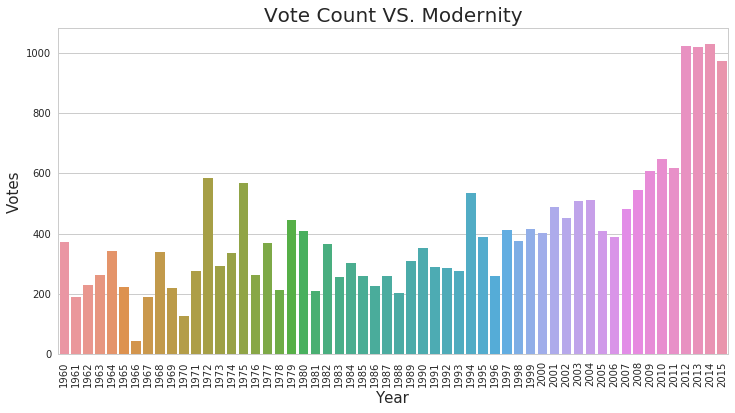

In [55]:
plt.figure(figsize=(12,6))
sns.set(style = 'whitegrid')
x = df.groupby('release_year')['vote_count'].mean()
ax= sns.barplot(x.index, x)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Votes', fontsize = 15)
plt.title('Vote Count VS. Modernity', fontsize=20)
plt.xticks(rotation = 90)
plt.show()

<a id = "q4"> </a>
### Research Question 4 (How much Every Production company contribute in industry)

In [62]:
dp = df['production_companies'].str.get_dummies(sep='|') # Create new frame contain caompanies names

In [63]:
dpc=dp[dp.columns].apply(lambda x: sum(x.values)) 

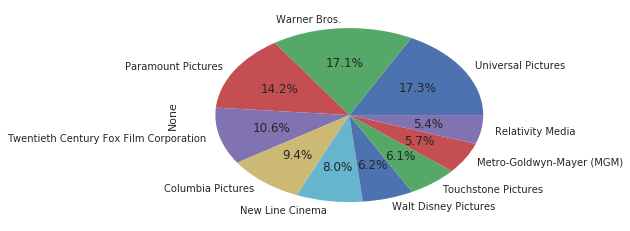

In [70]:
# Plot excution for Top 10 companies
dpc.sort_values(0,ascending=False).head(10).plot.pie(autopct="%1.1f%%",frame=False)
plt.show()

<a id = "q5"> </a>
### Research Question 5  (Number Of Released Movies Variation Thru Years)

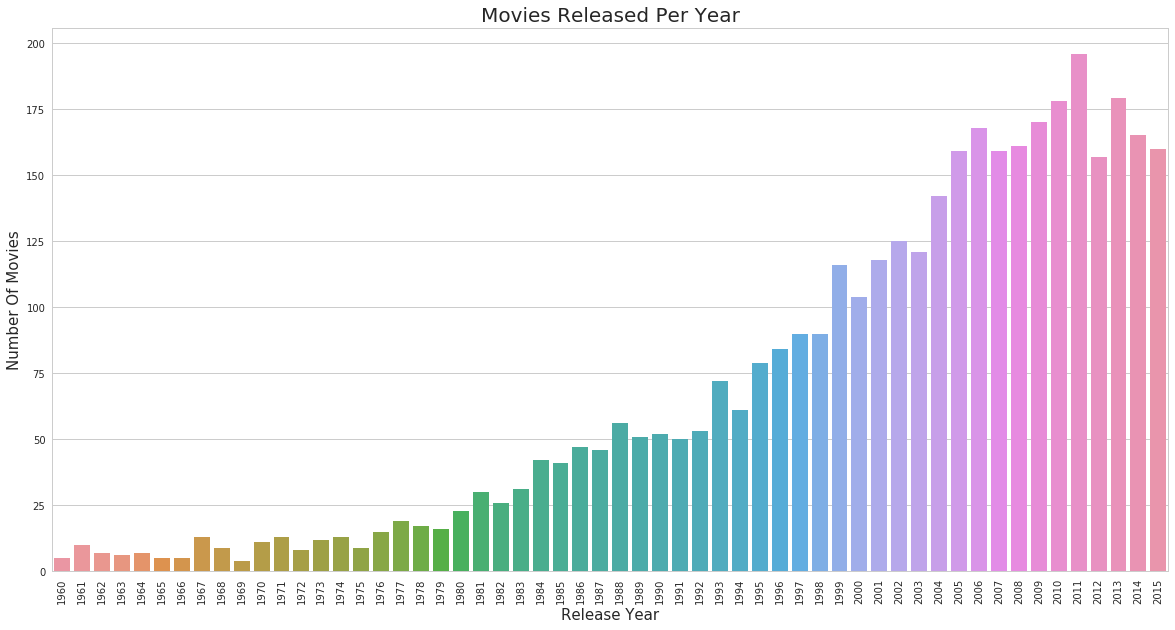

In [61]:
plt.figure(figsize=(20,10))
sns.countplot(df['release_year'])
plt.title('Movies Released Per Year', fontsize = 20)
plt.xlabel('Release Year', fontsize = 15)
plt.ylabel('Number Of Movies', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

<a id = "q6"> </a>
### Research Question 6  (Which Directors has most movies!)

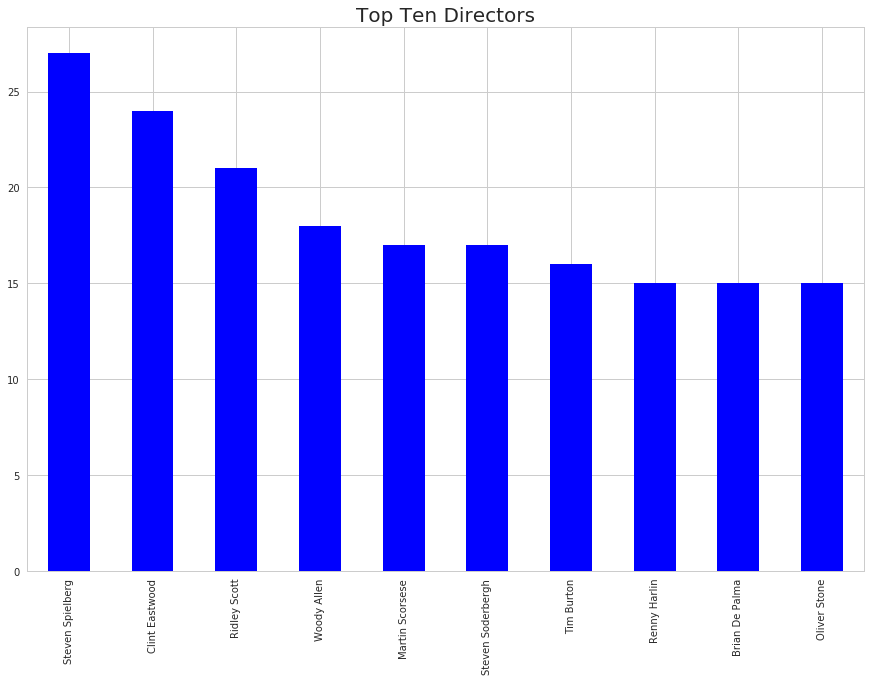

In [77]:
df['director'].value_counts().head(10).plot.bar(figsize=(15,10),color = 'blue')
plt.title('Top Ten Directors', fontsize=20)
plt.show()

<a id='conclusions'></a>
## Conclusions
### From Previous Question's answer we conclude:
>**Frist:** Drama type movies is the most popular genre at all, and foreign movies doesn't have large interesting 
<a href="#q1">Explore analysis</a>

>**Second:** Avatar has largest revenue all times
<a href="#q2">Explore analysis</a>

>**Third:** Modernity isn't the only aspect of voting beacause 2014's movies has higher rating than 2015's movies.
<a href="#q3">Explore analysis</a>

>**Fourth:** Most effective production company is Universal Pictuers
<a href="#q4">Explore analysis</a>

>**Fifth:** 2011 has the most released number of movies all time
<a href="#q5">Explore analysis</a>

>**Sixth:** Steven Spielberg Directed Movies greater than any other directors
<a href="#q6">Explore analysis</a>


## Limitations

> **First: Money Value Through Years**
> It is injustice to compare different movies in different eras without take in considration inflation, or econemic depression
we can not treat on dollar from sixties with one dollar from this millenium

> **Second: Population in Each Movie Time**
> Revenue is function od audiance number which function of overall population, Which differs from time to time(Must take into considration)


In [3]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0